# Startup Recommendation Engine

In [1]:
import pandas as pd
import numpy as np

**Note:** Uncomment Below To Query From MongoDB

In [1]:
"""
#Use script to upload CSV to mongodb

from pymongo import MongoClient
client = MongoClient('localhost', 27017)
client.list_database_names()
startups = client['startups']
res = startups['sf_startups'].find()
res_list = [item for item in res]
sf_all_df = pd.DataFrame(res_list)
""";


In [188]:
sf_all_df = pd.read_csv("startups_sf_2004-14_data.csv")

In [189]:
sf_all_df.columns

Index(['company_permalink', 'company_name', 'company_category_list',
       'company_market', 'company_country_code', 'company_state_code',
       'company_region', 'company_city', 'investor_permalink',
       'fILIPPO Murroni', 'investor_category_list', 'investor_market',
       'investor_country_code', 'investor_state_code', 'investor_region',
       'investor_city', 'funding_round_permalink', 'funding_round_type',
       'funding_round_code', 'funded_at', 'funded_month', 'funded_quarter',
       'funded_year', 'raised_amount_usd'],
      dtype='object')

In [190]:
sf_companies = sf_all_df.fillna(0)[["company_name","company_market","company_city","company_category_list"]].drop_duplicates()

In [191]:
sf_companies = sf_companies.reset_index(drop=True)

In [192]:
import pickle 

with open('investor_rating_dict.pickle', 'rb') as handle:
    investor_rating_dict = pickle.load(handle)
    
with open('funding_dict.pickle', 'rb') as handle:
    funding_dict = pickle.load(handle)
    
with open('max_rounds_dict.pickle', 'rb') as handle:
    max_rounds_dict = pickle.load(handle)

In [193]:
sf_companies["total_funding"] = sf_companies["company_name"].map(funding_dict)

In [194]:
sf_companies["investor_rating"] = sf_companies["company_name"].map(investor_rating_dict)

In [195]:
sf_companies["company_max_round"] = sf_companies["company_name"].map(max_rounds_dict)

In [196]:
sf_companies[sf_companies["company_name"]=="Tesla Motors"]

,company_name,company_market,company_city,company_category_list,total_funding,investor_rating,company_max_round
17,Tesla Motors,Automotive,Palo Alto,|Automotive|,823.0,9.852941,6.0


# Data Visualizations

In [197]:
import matplotlib.pyplot as plt

In [198]:
from scipy.stats import boxcox

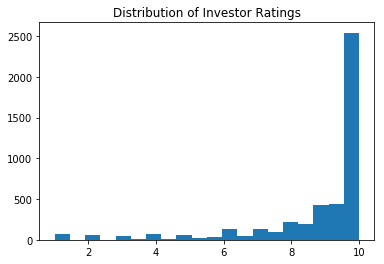

In [199]:
plt.hist(list(sf_companies["investor_rating"].fillna(1)),bins=20)
plt.title("Distribution of Investor Ratings");

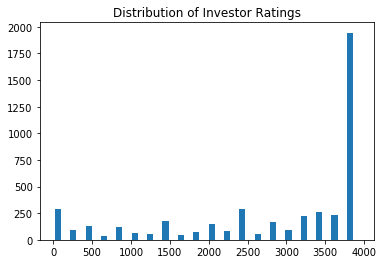

In [200]:
transformed_investor_data = boxcox(list(sf_companies["investor_rating"].fillna(1)))
plt.hist(transformed_investor_data,bins=20)
plt.title("Distribution of Investor Ratings");

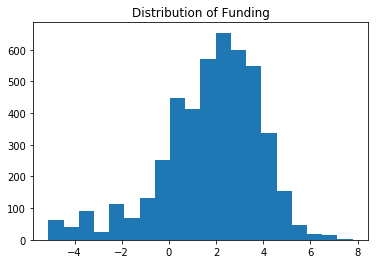

In [201]:
plt.hist(list(sf_companies["total_funding"].fillna(0.01).apply(np.log)),bins=20);
plt.title("Distribution of Funding");

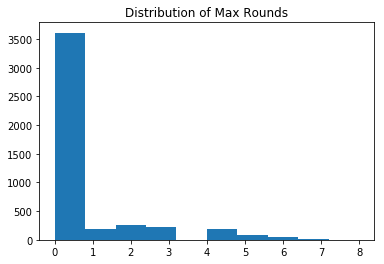

In [202]:
plt.hist(list(sf_companies["company_max_round"].fillna(0)),bins=10);
plt.title("Distribution of Max Rounds");

### Normalizing Company Rounds Data

No Transformation seems to help

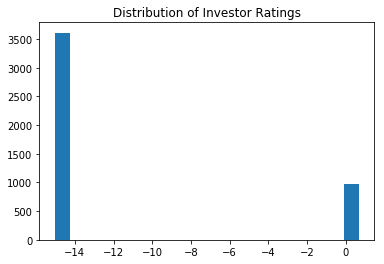

In [203]:
transformed_rounds_data = boxcox(list(sf_companies["company_max_round"].fillna(0).map(lambda x: 0.11 if x == 0 else x )))
plt.hist(transformed_rounds_data[0],bins=20)
plt.title("Distribution of Investor Ratings");

In [204]:
df = sf_companies.fillna(0)

In [205]:
df['total_funding'] = list(sf_companies["total_funding"].fillna(0.01).apply(np.log))
df['company_max_round'] = transformed_rounds_data[0]

print(df.shape)
df.head()

(4589, 7)


,company_name,company_market,company_city,company_category_list,total_funding,investor_rating,company_max_round
0,VirtualLogix,Software,Sunnyvale,|Mobile|Virtualization|Software|,3.377211,10.000000,0.443338
1,Deem,E-Commerce,San Francisco,|Trading|Marketplaces|Content Syndication|Prod...,6.247860,9.821429,0.674540
2,Pandora Media,Broadcasting,Oakland,|Broadcasting|Video Streaming|Music|,4.030695,9.727273,0.611076
3,PlayFirst,Games,San Francisco,|iPhone|Mobile Games|Games|,3.630190,10.000000,0.560349
4,Socialtext,Enterprise Software,Palo Alto,|Collaboration|Software|Networking|Web Tools|E...,3.845242,9.818182,0.611076


## EDA Most Common Words

In [206]:
import matplotlib.pyplot as plt

keywords = df['company_category_list'].map(lambda x: str(x).lower().split("|"))
keywords = [item for sublist in keywords for item in sublist]

from collections import Counter

common_category_words = Counter(keywords).most_common(30)
common_category_words.pop(0)

common_market_words = Counter(list(df['company_market'])).most_common(30)

common_cities = Counter(list(df['company_city'])).most_common(30)

In [208]:
def create_plot(x, y, title, x_label, y_label):
    plt.figure(figsize=(15,8))
    plt.bar(x,y)
    plt.xticks(rotation=90);
    plt.title(title,fontsize=20)
    plt.xlabel(x_label,fontsize=20)
    plt.xticks(fontsize=15)
    plt.ylabel(y_label,fontsize=25)
    plt.yticks(fontsize=15)
    plt.show()
    

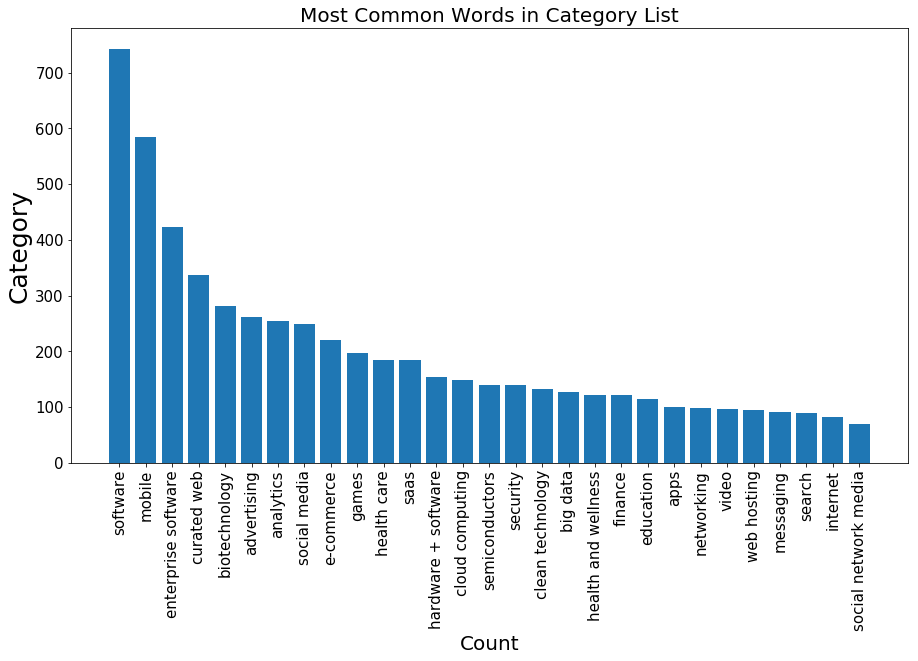

In [209]:
x = [w[0] for w in common_category_words]
y = [w[1] for w in common_category_words]

create_plot(x, y, "Most Common Words in Category List", "Count", "Category")

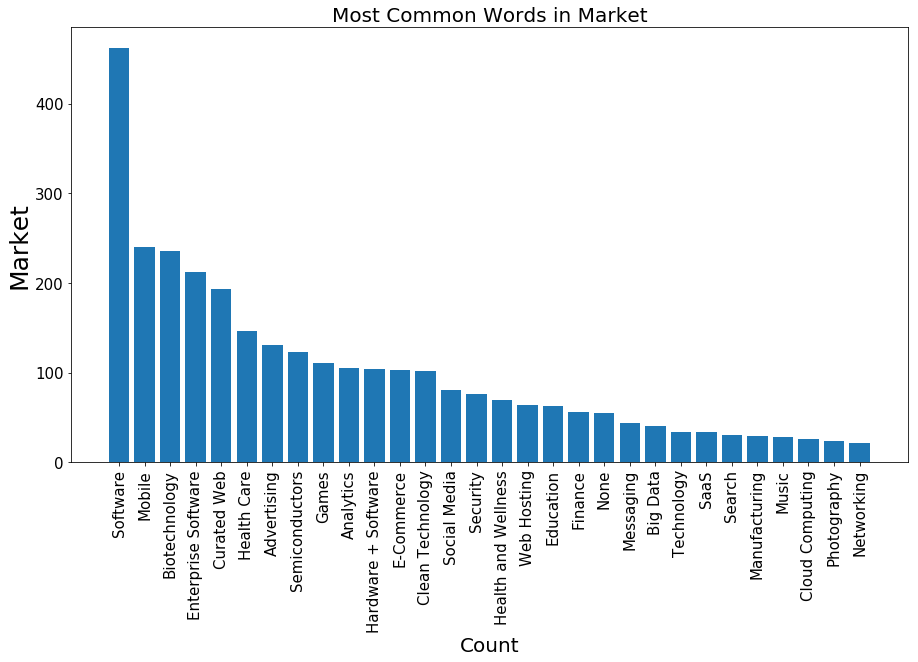

In [210]:
x = [w[0] if w[0] != 0 else 'None' for w in common_market_words]
y = [w[1] if w[1] != 0 else 'None' for w in common_market_words]

create_plot(x, y, "Most Common Words in Market", "Count", "Market")

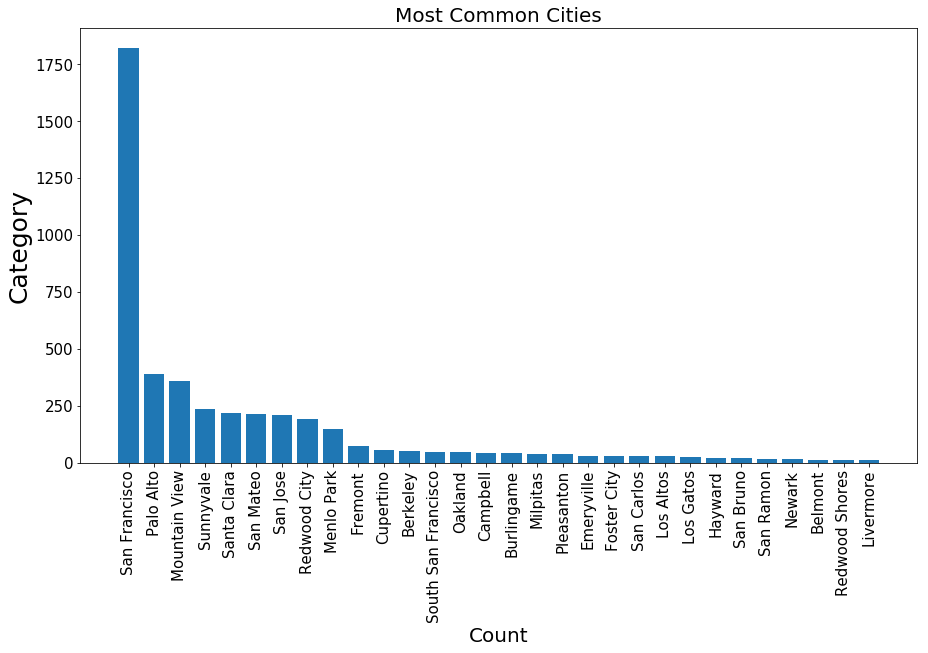

In [211]:
x = [w[0] for w in common_cities]
y = [w[1] for w in common_cities]

create_plot(x, y, "Most Common Cities", "Count", "Category")

## Clustering Section

In [97]:
import re

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing


def clustify(df, k_keywords):
    
    """
    params: df = dataframe of startups
            k_keywords = number of clusters for keywords in category list
            
    description: This function cleans and vectorizes the company_category_list. It is then clustered by categories 
                 and added to the dataframe. The subsets of clusters are copied to X_prescaling for scaling
                 before the final clustering.
    
    returns: The dataframe with the clusters as a feature
    """

    X_keyword = df['company_category_list'].map(lambda x: ' '.join(str(x).lower().split("|")))
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X_keyword)

    model = KMeans(n_clusters=k_keywords, init='k-means++', max_iter=100, n_init=1)
    keyword_clusters = model.fit_predict(X_vectorized)
    
    """   
    print("Top terms per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    for i in range(k_keywords):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :5]:
            print(' %s' % terms[ind]),
        print
    """
    
    keyword_cluster_dict = dict(zip(list(df['company_name']),keyword_clusters))
    df['keyword_clusters'] = df['company_name'].map(keyword_cluster_dict)
    
    #Cluster the already keyword clustered data
    final_cluster_dict = {}
    max_k_inner = 0
    
    for k_inner in range(k_keywords):
        
        df_subset = df[df["keyword_clusters"]==k_inner]
        
        if df_subset.shape[0] <= 5:
            max_k_inner +=1
            final_cluster_dict = dict(list(final_cluster_dict.items()) + list(dict(zip(list(df_subset['company_name']), [max_k_inner]*df_subset.shape[0])).items())) 
            #print (final_cluster_dict)
        
        else:
            '''
            The number of clusters within the keywords clusters is the floor of startups in a cluster divided by 5
            '''
            k_nums = int(df_subset.shape[0]/5) 
            
            X_prescaling = df_subset[['total_funding','company_max_round','investor_rating']]
            X_prescaling = X_prescaling.fillna(0)
            X_scaled  = pd.DataFrame(preprocessing.scale(X_prescaling))
            #X_scaled['company_name'] = df['company_name']
        
            num_clust = KMeans(n_clusters=k_nums)
            num_clusters = num_clust.fit_predict(X_scaled)   
            adj_num_clusters = [x + max_k_inner for x in num_clusters]
            
            max_k_inner += k_nums
            
            final_cluster_dict = dict(list(final_cluster_dict.items()) + list(dict(zip(list(df_subset['company_name']), adj_num_clusters)).items()))
    
        df['final_cluster'] = df['company_name'].map(final_cluster_dict)
    
    return df


In [81]:
clustify(sf_companies, 30)

,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
0,VirtualLogix,Software,Sunnyvale,|Mobile|Virtualization|Software|,Sunnyvale,29.288979,10.000000,2.0,9,501
1,Deem,E-Commerce,San Francisco,|Trading|Marketplaces|Content Syndication|Prod...,San Francisco,516.905435,9.821429,8.0,9,303
2,Pandora Media,Broadcasting,Oakland,|Broadcasting|Video Streaming|Music|,Oakland,56.300000,9.727273,4.0,0,9
3,PlayFirst,Games,San Francisco,|iPhone|Mobile Games|Games|,San Francisco,37.720000,10.000000,3.0,19,731
4,Socialtext,Enterprise Software,Palo Alto,|Collaboration|Software|Networking|Web Tools|E...,Palo Alto,46.770000,9.818182,4.0,9,506
5,SideStep,Hotels,Santa Clara,|Ticketing|Hotels|Travel|,Santa Clara,32.000000,10.000000,3.0,9,444
6,Soundflavor,Music,San Francisco,|Ediscovery|Music|,San Francisco,5.800000,7.400000,1.0,28,906
7,Executive Caddie,iPhone,Mountain View,|Windows Phone 7|iPhone|Sports|Software|,Mountain View,3.000000,6.000000,0.0,9,452
8,VisualOn,Software,San Jose,|Software|,San Jose,2.700000,7.500000,2.0,1,60
9,Innovative Silicon,Semiconductors,Santa Clara,|Semiconductors|,Santa Clara,72.000000,10.000000,3.0,8,278


## Choose K for clusters

Selecting 30 after looking at graph

In [17]:
range_n_clusters = list(range(2,50))
scores = []              
for n_clusters in range_n_clusters:

    X_keyword = df['company_category_list'].map(lambda x: ' '.join(str(x).lower().split("|")))
    vectorizer = TfidfVectorizer()
    X_vectorized = vectorizer.fit_transform(X_keyword)

    model = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1)

    cluster_labels = model.fit_predict(X_vectorized)

    silhouette_avg = silhouette_score(X_vectorized, cluster_labels)
    scores.append(silhouette_avg)
    #print("For n_clusters =", n_clusters,
    #      "The average silhouette_score is :", silhouette_avg)

Text(0,0.5,'Silhouette Score')

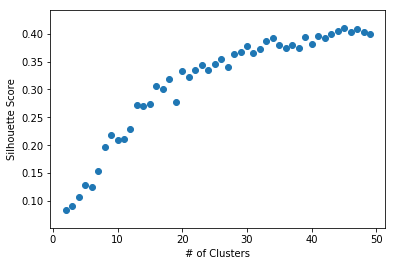

In [18]:
plt.scatter(list(range(2,50)),scores)
plt.xlabel("# of Clusters")
plt.ylabel("Silhouette Score")

In [98]:
clustered_df = clustify(df,30)
clustered_df

,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
0,VirtualLogix,Software,Sunnyvale,|Mobile|Virtualization|Software|,Sunnyvale,29.288979,10.000000,2.0,7,391
1,Deem,E-Commerce,San Francisco,|Trading|Marketplaces|Content Syndication|Prod...,San Francisco,516.905435,9.821429,8.0,20,725
2,Pandora Media,Broadcasting,Oakland,|Broadcasting|Video Streaming|Music|,Oakland,56.300000,9.727273,4.0,5,194
3,PlayFirst,Games,San Francisco,|iPhone|Mobile Games|Games|,San Francisco,37.720000,10.000000,3.0,23,813
4,Socialtext,Enterprise Software,Palo Alto,|Collaboration|Software|Networking|Web Tools|E...,Palo Alto,46.770000,9.818182,4.0,7,388
5,SideStep,Hotels,Santa Clara,|Ticketing|Hotels|Travel|,Santa Clara,32.000000,10.000000,3.0,7,315
6,Soundflavor,Music,San Francisco,|Ediscovery|Music|,San Francisco,5.800000,7.400000,1.0,7,309
7,Executive Caddie,iPhone,Mountain View,|Windows Phone 7|iPhone|Sports|Software|,Mountain View,3.000000,6.000000,0.0,7,416
8,VisualOn,Software,San Jose,|Software|,San Jose,2.700000,7.500000,2.0,1,48
9,Innovative Silicon,Semiconductors,Santa Clara,|Semiconductors|,Santa Clara,72.000000,10.000000,3.0,13,595


In [106]:
clustered_df[clustered_df["final_cluster"]==6]

,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
833,Bill.com,SaaS,Palo Alto,|SaaS|Finance|,Palo Alto,72.6,9.851852,5.0,0,6


In [20]:
def check_cluster_sizes(value_counts):
    list_ = list(zip(value_counts.keys(),value_counts.values))
    return(list_)

In [112]:
print("(Cluster number, Amount in cluster)")
print("-------")
print(check_cluster_sizes(clustered_df['final_cluster'].value_counts()))

(Cluster number, Amount in cluster)
-------
[(266, 83), (367, 54), (250, 49), (37, 40), (328, 39), (169, 34), (134, 34), (210, 33), (335, 33), (811, 32), (612, 32), (717, 28), (55, 26), (761, 25), (669, 25), (857, 25), (537, 25), (579, 23), (467, 23), (900, 22), (774, 22), (8, 22), (741, 21), (701, 21), (504, 21), (393, 20), (523, 20), (119, 20), (629, 20), (92, 20), (692, 20), (563, 19), (662, 19), (479, 18), (459, 18), (276, 18), (161, 18), (271, 18), (884, 18), (836, 17), (0, 17), (280, 17), (244, 17), (112, 17), (544, 17), (312, 16), (738, 16), (872, 16), (296, 16), (111, 16), (514, 16), (353, 16), (80, 16), (241, 16), (26, 15), (576, 15), (490, 15), (410, 15), (711, 15), (649, 15), (182, 15), (74, 14), (469, 14), (141, 14), (364, 14), (138, 14), (518, 14), (84, 14), (832, 14), (592, 14), (261, 13), (291, 13), (577, 13), (724, 13), (68, 13), (125, 13), (804, 13), (200, 13), (319, 13), (489, 13), (797, 13), (465, 12), (234, 12), (793, 12), (96, 12), (232, 12), (573, 12), (700, 12), 

In [33]:
#clustered_df.to_csv('clustered_df.csv',sep=',',index=False)

## Function To Filter Precomputed Data

In [23]:
def showTopCompanies(df, enteredCompany):
    
    """
    params: df = dataframe of startups
            enteredCompany = company of name of interest 
            
    description: Filters the dataframe to show companies within the same cluster as the comapny of interest
    
    returns: dashboard and the clustered companies
            
    """
    
    company_data = df[df["company_name"]==enteredCompany]
    cluster_group = company_data.iloc[0]['final_cluster']    
    group = df[df['final_cluster']==cluster_group]
    
    fig = dashboard(group, enteredCompany)
    plot(fig, filename='name.html', auto_open=False)
    
    return fig, group

## Experimental Dashboard Functionality

See README for link to deployed dashboard

In [24]:
from plotly import tools
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def dashboard(df_plt, company_name):
    
    """
    params: df_plt = dataframe to be plotted
            company_name = startup of interest
            
    description: creates subplots to display various metrics of companies that were clustered together.
    
    returns: displays a figure with subplots and the object is returned as well. 
    """
    
    searched_df = df_plt[df_plt['company_name'] == company_name]
    similar_df = df_plt[df_plt['company_name'] != company_name]
    
    '''
    #Plotly doesn't support tables subplot, needs to be removed for subplot
    trace1 = go.Table(
        header=dict(values=[1,2],
                    #fill = dict(color='#C2D4FF'),
                    align = ['left'] * 5),
        cells=dict(values=[1,2],
                   #fill = dict(color='#F5F8FF'),
                   align = ['left'] * 5)
    )
    '''
    
    trace2 = go.Bar(
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['total_funding']) + list(similar_df['total_funding']),
        #text=['Text A', 'Text B', 'Text C'],
    )
    
    trace3 = go.Bar(
        name='Test',
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['company_max_round']) + list(similar_df['company_max_round']),
        #text=['Text D', 'Text E', 'Text F'],
    )
    
    trace4 = go.Bar(
        name='Test',
        x=[x for x in searched_df['company_name']] + [x for x in similar_df['company_name']],
        y=list(searched_df['investor_rating']) + list(similar_df['investor_rating']),
        #text=['Text D', 'Text E', 'Text F'],
    )
    
    fig = tools.make_subplots(rows=2, cols=3,subplot_titles=('Total Funding', 'Rounds','Investor Rating'))

    #fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 1)
    fig.append_trace(trace3, 1, 2)
    fig.append_trace(trace4, 1, 3)


    fig['layout'].update(height=600, width=800,showlegend = False, title=f'Companies Similar To *{company_name}*')
    #py.iplot(fig, filename='simple-subplot-with-annotations')
    iplot(fig,filename='basic')
    
    return fig

## Example Dashboard

In [111]:
fig, group = showTopCompanies(clustered_df, 'Pure Storage')
group

This is the format of your plot grid:
[ (1,1) x1,y1 ]  [ (1,2) x2,y2 ]  [ (1,3) x3,y3 ]
[ (2,1) x4,y4 ]  [ (2,2) x5,y5 ]  [ (2,3) x6,y6 ]



,company_name,company_market,company_city,company_category_list,company_city,total_funding,investor_rating,company_max_round,keyword_clusters,final_cluster
1598,Pure Storage,Storage,Mountain View,|Storage|Enterprise Software|,Mountain View,534.856468,10.000000,0.0,19,723
1899,Violin Memory,Technology,Santa Clara,|Technology|Storage|Semiconductors|,Santa Clara,268.412808,9.777778,0.0,19,723
2339,Nutanix,Enterprise Software,San Jose,|Virtualization|Storage|Enterprise Software|,San Jose,312.200000,10.000000,0.0,19,723


In [27]:
#Code Is Deployed In Web App. See App Folder